# [In Progress]

# Programación Entera: Heurísticas para el Problema de la Mochila

#### Descripción

TODO

#### Autor
  
  * Sergio García Prado - [garciparedes.me](https://garciparedes.me)
  
#### Fecha

  * Mayo de 2018


## Contenidos
  * [Introducción](#Introducción)
  * [Problema de la Mochila](#Problema-de-la-Mochila)
    * [Mochila Simple](#Mochila-Simple)
    * [Mochila Múltiple](#Mochila-Múltiple)
    * [Mochila Multidimensional](#Mochila-Multidimensional)
  * [Problema de Empaquetamiento](#Problema-de-Empaquetamiento)
  * [Conclusiones](#Conclusiones)

## Introducción

TODO

#### Configuración del Entorno

In [1]:
rm(list = ls())

In [2]:
library(slam, warn.conflicts = FALSE)
library(Rglpk, warn.conflicts = FALSE)
library(purrr, warn.conflicts = FALSE)
library(magrittr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(ggthemes, warn.conflicts = FALSE)
library(scales, warn.conflicts = FALSE)

Using the GLPK callable library version 4.65


In [3]:
options(repr.matrix.max.rows = 600, repr.matrix.max.cols = 600)

#### Constantes y Funciones de Apoyo

In [4]:
dataset.root <- "./data/"
dataset.folder <- "./data/knapsack/"
dataset.folder.simple <- paste0(dataset.folder, "simple/")
dataset.folder.multi  <- paste0(dataset.folder, "multidimensional/")
dataset.folder.binpacking <- paste0(dataset.root, "binpacking/")

In [5]:
ReadSimpleKnapsack <- function(file.path) {
    con <- 
        file.path %>%
        file(open = "r")
    raw <- 
        con %>%
        readLines(warn = FALSE) %>% 
        strsplit("[[:blank:]]") %>%
        unlist() %>%
        as.double()
    close(con)
    list(
        n        = raw[1],
        capacity = raw[2] ,
        value    = raw[seq(4, length(raw), by = 3)],
        weight   = raw[seq(5, length(raw), by = 3)]
    ) %>%
    return()
}

In [6]:
SimpleKnapsackSubSet <- function(p, selected, capacity = p$capacity){
    if (sum(selected) > 0) {
       list(n        = sum(selected),
            capacity = capacity,
            value    = p$value[selected],
            weight   = p$weight[selected]
        ) %>%
        return()
    }
}

In [7]:
ReadMultidimensionalKnapsack <- function(file.path) {
    con <- 
        file.path %>%
        file(open = "r")
    raw <- 
        con %>%
        readLines(warn = FALSE) %>% 
        strsplit("[[:blank:]]") %>%
        unlist() %>%
        as.double()
    close(con)
    list(n        = raw[1],
         m        = raw[2],
         objval   = raw[3],
         value    = raw[4:(raw[1]+ 3)],
         weight   = matrix(raw[(4 + raw[1]):(3 + raw[1] * (1 + raw[2]))], 
                           ncol = raw[1], byrow = TRUE),
         capacity = raw[(4 + raw[1] * (1 + raw[2]) ):length(raw)]
    ) %>%
    return()
}

In [8]:
ReadBinPacking <- function(file.path) {
    con <- 
        file.path %>%
        file(open = "r")
    raw <- 
        con %>%
        readLines(warn = FALSE) %>% 
        strsplit("[[:blank:]]") %>%
        unlist()
    close(con)
    
    name <- raw[1]
    raw.numeric <- 
        raw[2:length(raw)] %>%
        as.double()

    list(name     = name,
         capacity = raw.numeric[1],
         n        = raw.numeric[2],
         objval   = raw.numeric[3],
         size     = raw.numeric[4:length(raw.numeric)]
    ) %>%
    return()
}

In [9]:
Solve <- function(f.obj, f.con, f.dir, f.rhs, ...) {
    Rglpk_solve_LP(f.obj, f.con, f.dir, f.rhs, ...)
}

In [10]:
PlotKnapsackSolutions <- function(s) {
    options(repr.plot.height = 2, repr.plot.width = 8)
    lapply(s, function(x) {
        x$objval
    }) %>%
    unlist() %>%
    stack() %>% 
    dplyr::mutate(ind = factor(ind, levels = c("exact", "relaxed", "rounded", "greedy", "local"), 
                               labels = list(exact   = "Exacto", relaxed     = "Relajación Lineal", 
                                             rounded = "H. Redondeo", greedy = "H. Greedy",
                                             local   = "H. Búsqueda Local"))) %>% {
    ggplot(data = ., aes(x = reorder(ind, -values), y = values, fill = ind, label = round(values, digits = 2))) + 
        scale_y_continuous(limits = range(.$values) + (max(.$values) - min(.$values)) * c(-0.15, 0.15), 
                           oob = rescale_none) +
        geom_bar(stat="identity") + 
        ggtitle("Resultados") +
        ylab("Valor Objetivo") + 
        xlab("Método") + 
        theme(plot.title = element_text(hjust = 0.5)) +
        guides(fill = guide_legend(title="Método")) +
        geom_text(position = position_dodge(width = 0.9), 
                  vjust = 1.5, color = "white") 
    }    
}

## Problema de la Mochila

#### Descripción:
TODO

### Mochila Simple

#### Descripción:
TODO

#### Modelo:
TODO

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Maximizar} & \displaystyle \sum\limits_{j=1}^{n} p_{j} \cdot x_{j} \\
      \text{sujeto a}  & \sum\limits_{j=1}^{n} w_{j} \cdot x_{j} \leq c \\
                       & x_{j} \in \{0, 1\}, & \forall j \in \{1,...,n\}
    \end{array}
\end{equation}

In [11]:
KnapsackSimpleExact <- function(p, types = "B", max = TRUE, ...) {
    Solve(p$value, rbind(matrix(p$weight, nrow = 1, byrow = TRUE), diag(p$n)), 
          rep("<=", length(p$capacity) + p$n), c(p$capacity, rep(1, p$n)), types = types, 
          max = max, ...)
}

#### Heurísticas:
TODO

In [12]:
KnapsackSimpleRounding <- function(p, InitialSolution = KnapsackSimpleExact, 
                                   RoundingFunction = floor, ...) {
    sol.exact <- InitialSolution(p, types = "C", ...)
    
    sol <- list()
    sol$solution = RoundingFunction(sol.exact$solution)
    sol$objval   = sum(sol$solution * p$value)
    sol$slack    = p$capacity - sum(sol$solution * p$weight)
    return(sol)
}

In [13]:
RelativeCriterion <- function(p) {
    p$value/p$weight
}

In [14]:
KnapsackSimpleGreedy <- function(p, Criterion = RelativeCriterion, ...) {
    sol <- list(solution = rep(0, p$n), 
                objval = 0, slack = p$capacity)
    
    g <- Criterion(p)
    i <- which(g == max(g[sol$solution == 0]) & sol$solution == 0)[1]
    
    while (!is.na(i) && sol$slack - p$weight[i] > 0) {
        sol$solution[i] <- 1
        sol$objval <- sol$objval + p$value[i]
        sol$slack <- sol$slack - p$weight[i]
        
        if (any(sol$solution == 0)) {
            i <- which(g == max(g[sol$solution == 0]) & sol$solution == 0)[1]    
        } else {
            i <- NA
        }
    }
    return(sol)
}

In [15]:
KnapsackSimpleLocalSearchBest <- function(p, slack, idx0, idx1) {
    best = list(v = 0, i = 0, j = 0)
    for (i in idx0) {
        for (j in idx1) {
            if (slack + p$weight[j] - p$weight[i] > 0) {
                v.temp <- p$value[i] - p$value[j]
                if(best$v < v.temp) {
                    best$v <- v.temp
                    best$i <- i
                    best$j <- j
                }   
            }
        }
    }
    return(best)
}

In [16]:
KnapsackSimpleLocalSearch <- function(p, InitialSolution = KnapsackSimpleGreedy, ...) {
    sol <- InitialSolution(p, ...)
    
    idx0 <- which(sol$solution == 0)
    idx1 <- which(sol$solution == 1)
    
    best <- KnapsackSimpleLocalSearchBest(p, sol$slack, idx0, idx1)
    while (best$v > 0) {
        sol$solution[best$i] <- 1
        sol$solution[best$j] <- 0
        sol$slack <- sol$slack + p$weight[best$j] - p$weight[best$i]
        sol$objval <- sol$objval + best$v
        
        idx0 <- c(idx0[idx0 != best$i], best$j)
        idx1 <- c(idx1[idx1 != best$j], best$i)
        
        best <- KnapsackSimpleLocalSearchBest(p, sol$slack, idx0, idx1)
    }
    return(sol)    
}

### Ejemplos

In [17]:
GenerateSimpleKnapsackSolutions <- function(p, ...) {
    sol <- list()
    
    s <- KnapsackSimpleExact(p, ...)
    sol$exact <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                      objval   = s$optimum,
                      slack    = p$capacity - s$auxiliary$primal[1])

    s <- KnapsackSimpleExact(p, types = "C", ...)
    sol$relaxed <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                        objval   = s$optimum,
                        slack    = p$capacity - s$auxiliary$primal[1])

    s <- KnapsackSimpleRounding(p, ...)
    sol$rounded <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                        objval   = s$objval,
                        slack    = s$slack)

    s <- KnapsackSimpleGreedy(p, ...)
    sol$greedy <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                       objval   = s$objval,
                       slack    = s$slack)
    s <- KnapsackSimpleLocalSearch(p, ...)
    sol$local <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                      objval   = s$objval, 
                      slack    = s$slack)
    
    return(sol)
}

##### gen100.1

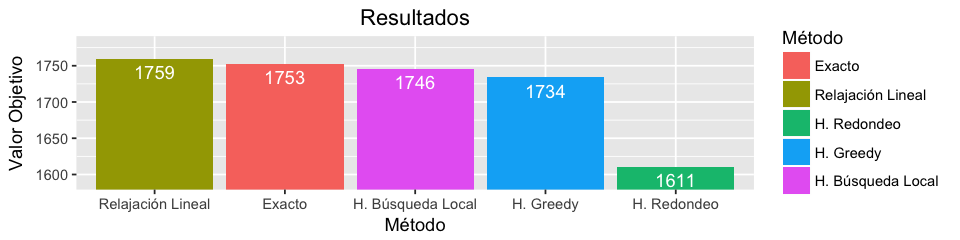

In [18]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen100_1.txt")) %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen100.2

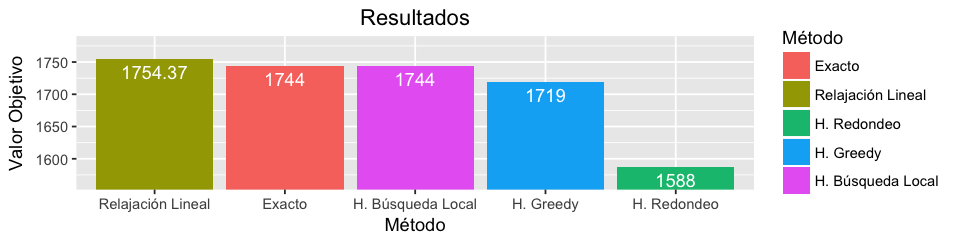

In [19]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen100_2.txt")) %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen100.3

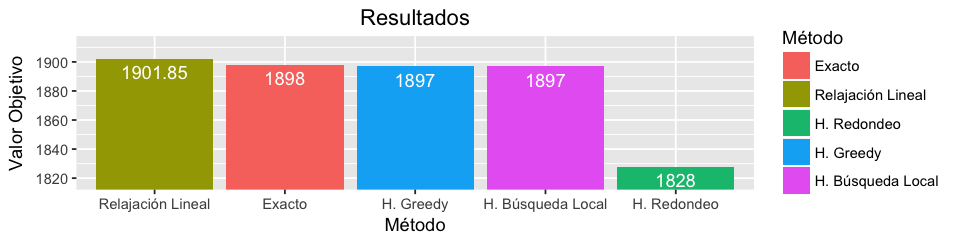

In [20]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen100_3.txt"))  %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen100.4

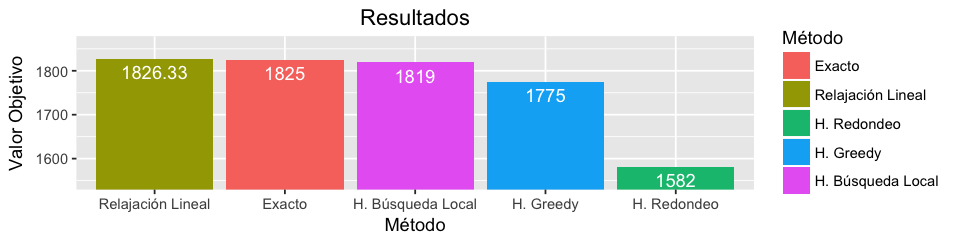

In [21]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen100_4.txt"))  %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen100.5

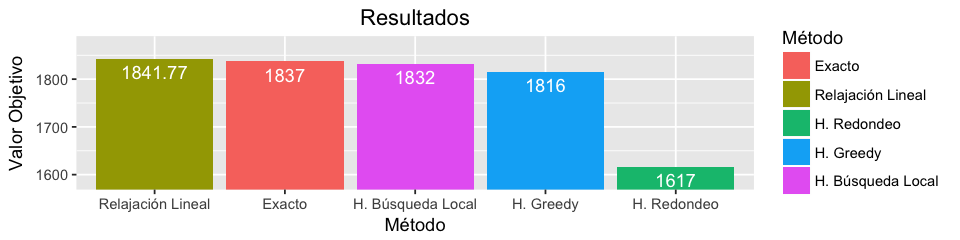

In [22]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen100_5.txt"))  %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen200.1

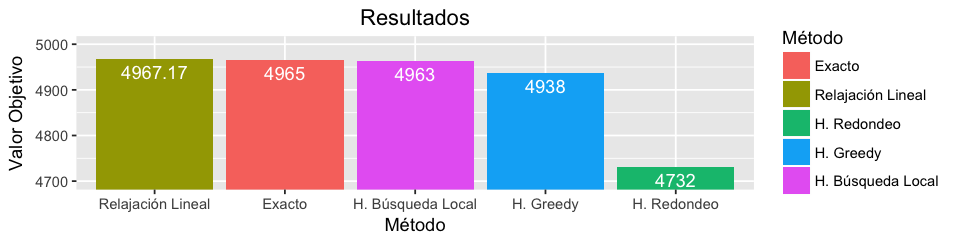

In [23]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen200_1.txt"))  %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen200.2

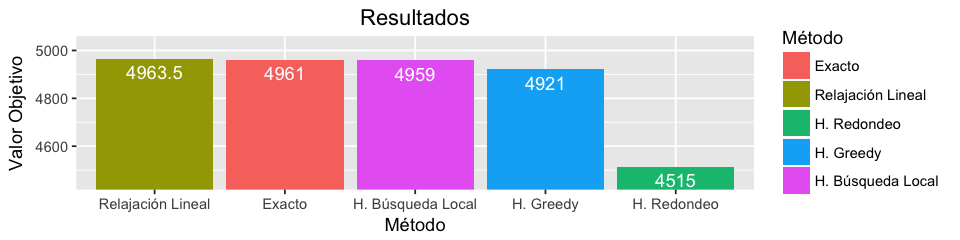

In [24]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen200_2.txt"))  %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen200.3

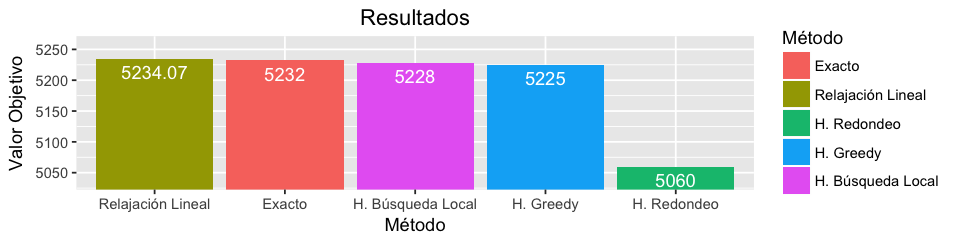

In [25]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen200_3.txt"))  %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen200.4

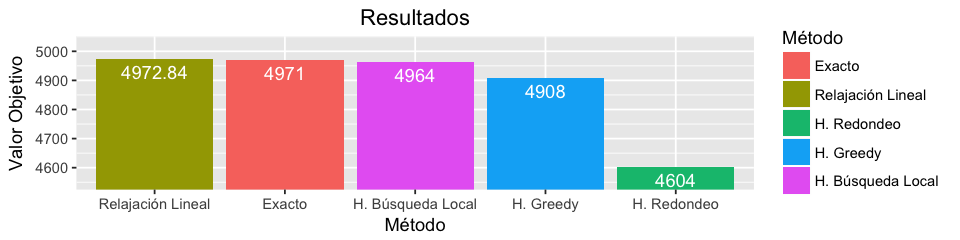

In [26]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen200_4.txt"))  %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen200.5

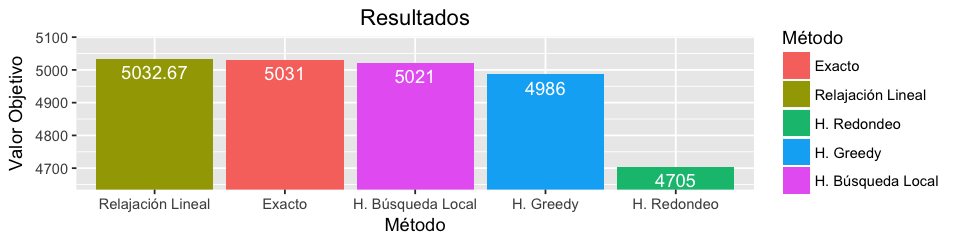

In [27]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen200_5.txt"))  %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen300.1

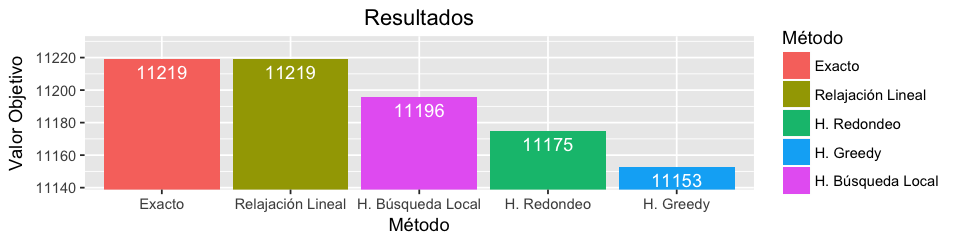

In [28]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen300_1.txt"))  %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen300.2

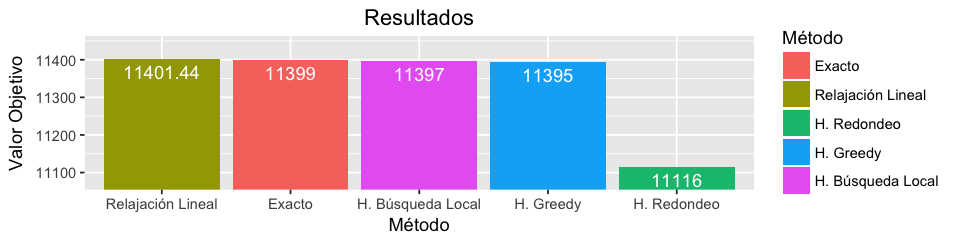

In [29]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen300_2.txt"))  %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen300.3

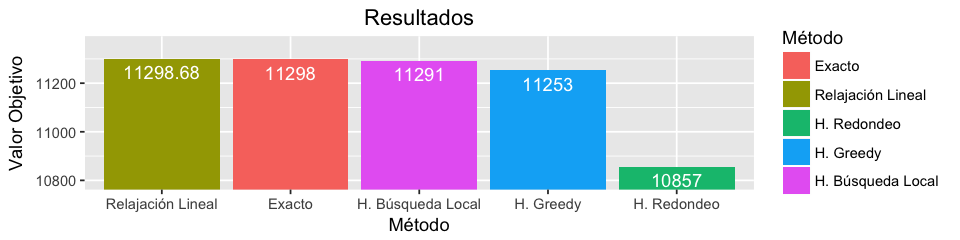

In [30]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen300_3.txt"))  %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen300.4

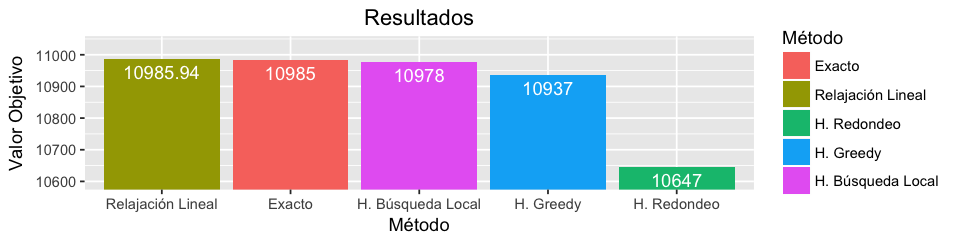

In [31]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen300_4.txt"))  %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen300.5

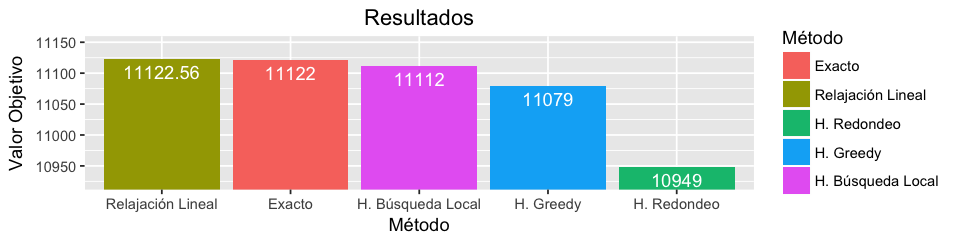

In [32]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen300_5.txt")) %>%
GenerateSimpleKnapsackSolutions() %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

### Mochila Múltiple

#### Descripción:
TODO

#### Modelo:
TODO

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Maximizar} & \displaystyle \sum\limits_{i=1}^{m}\sum\limits_{j=1}^{n} p_{j} \cdot x_{ij} \\
      \text{sujeto a}  & \sum\limits_{j=1}^{n} w_{j} \cdot x_{ij} \leq c, & \forall i \in \{1,...,m\} \\
                       & \sum\limits_{i=1}^{m} x_{ij} \leq 1, & \forall j \in \{1,...,n\} \\
                       & x_{ij} \in \{0, 1\}, 	& \forall i \in \{1,...,m\}, \forall j \in \{1,...,n\}
    \end{array}
\end{equation}

In [33]:
KnapsackMultipleExact <- function(p, m, types = "B", max = TRUE, ...) {
    conditions <- matrix(rep(0,(m + p$n) * p$n * m), 
                         nrow = m + p$n, ncol = p$n * m, byrow = TRUE)
    
    for(i in 1:m) {
        conditions[i, (i - 1) * p$n + 1:p$n] <- p$weight
    }
    for(i in (m + 1):(p$n + m)) {
        conditions[i, seq(i-m, p$n*m, by = p$n)] <- 1
    }

    Solve(rep(p$value, m), conditions, 
          c(rep("<=", m + p$n)),
          c(rep(p$capacity, m), rep(1, p$n)),
                 types = types, max = max, ...)
}

#### Heurísticas:
TODO

In [34]:
KnapsackMultipleRounding <- function(p, m, InitialSolution = KnapsackMultipleExact, 
                                     RoundingFunction = trunc, ...) {
    sol.exact <- InitialSolution(p, m, types = "C", ...)
    
    sol <- list()
    sol$solution = matrix(RoundingFunction(sol.exact$solution), nrow = m, byrow = TRUE)    
    sol$objval   = sum(t(sol$solution) * p$value)
    sol$slack    = p$capacity - colSums(t(sol$solution) * p$weight)
    return(sol)
}

In [35]:
KnapsackMultipleGreedy <- function(p, m, ...) {
    sol <- list(solution = matrix(rep(0, p$n * m), nrow = m), 
                objval = 0, slack = rep(p$capacity, m))

    for(i in 1:m) {
        p.i <- SimpleKnapsackSubSet(p, colSums(sol$solution) == 0)
        if(!is.null(p.i)) {
            s.i <- KnapsackSimpleGreedy(p.i, ...)
            sol$solution[i, colSums(sol$solution) == 0] <- s.i$solution
            sol$objval <- sol$objval + s.i$objval
            sol$slack[i] <- s.i$slack
        }
        
    }
    
    return(sol)
}

In [36]:
KnapsackMultipleLocalSearch <- function(p, m, InitialSolution = KnapsackMultipleGreedy, ...) {
    sol <- InitialSolution(p, m, ...)
    
    for(i in 1:m) {
        idx0 <- which(colSums(sol$solution) == 0)
        idx1 <- which(sol$solution[i, ] == 1)
    
        best <- KnapsackSimpleLocalSearchBest(p, sol$slack[i], idx0, idx1)
        while (best$v > 0) {
            sol$solution[i, best$i] <- 1
            sol$solution[i, best$j] <- 0
            sol$slack[i] <- sol$slack[i] + p$weight[best$j] - p$weight[best$i]
            sol$objval <- sol$objval + best$v

            idx0 <- c(idx0[idx0 != best$i], best$j)
            idx1 <- c(idx1[idx1 != best$j], best$i)

            best <- KnapsackSimpleLocalSearchBest(p, sol$slack[i], idx0, idx1)
        }
    }
    
    return(sol)
}

### Ejemplos

In [37]:
m <- 3

In [38]:
GenerateMultipleKnapsackSolutions <- function(p, m, ...) {
    sol <- list()
    
    # s <- KnapsackMultipleExact(p, m, ...)
    # sol$exact <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
    #                   objval   = s$optimum,
    #                   slack    = p$capacity - s$auxiliary$primal[1])
    
    s <- KnapsackMultipleExact(p, m, types = "C", ...)
    sol$relaxed <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                        objval   = s$optimum,
                        slack    = matrix(rep(p$capacity, m) - s$auxiliary$primal[m], 
                                          ncol = m, byrow =TRUE))

    s <- KnapsackMultipleRounding(p, m, ...)
    sol$rounded <- list(solution = s$solution,
                        objval   = s$objval,
                        slack    = matrix(s$slack, ncol = m, byrow = TRUE))

    s <- KnapsackMultipleGreedy(p, m, ...)
    sol$greedy <- list(solution = s$solution,
                       objval   = s$objval,
                        slack    = matrix(s$slack, ncol = m, byrow = TRUE))

    s <- KnapsackMultipleLocalSearch(p, m, ...)
    sol$local <- list(solution = s$solution, ncol = p$n,
                      objval   = s$objval,
                      slack    = matrix(s$slack, ncol = m, byrow = TRUE))
    
    return(sol)
}

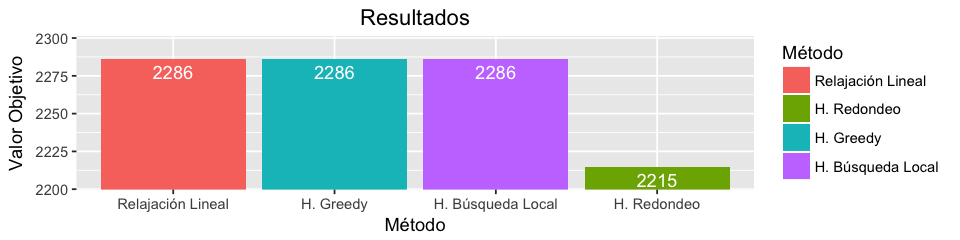

In [39]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen10_1.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

##### gen100.1

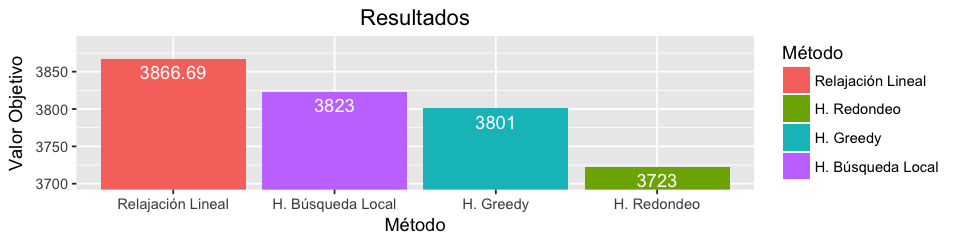

In [40]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen100_1.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen100.2

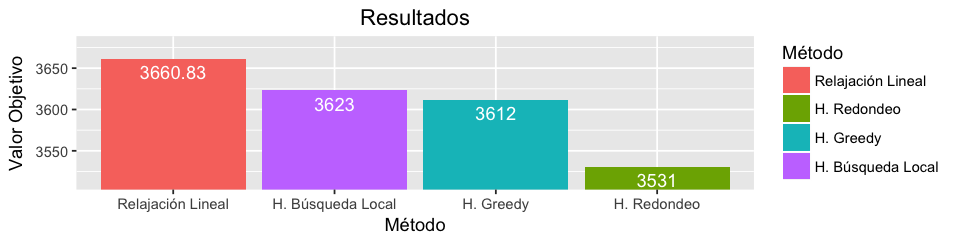

In [41]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen100_2.txt"))  %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen100.3

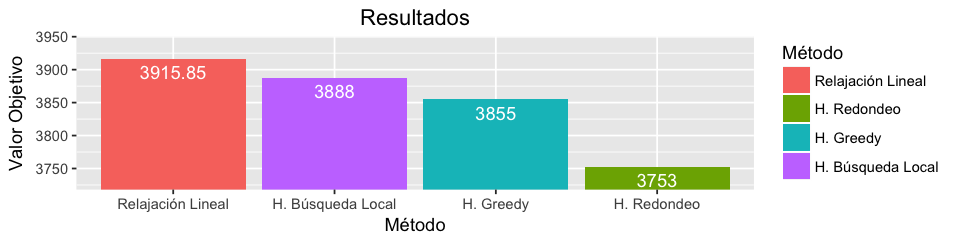

In [42]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen100_3.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen100.4

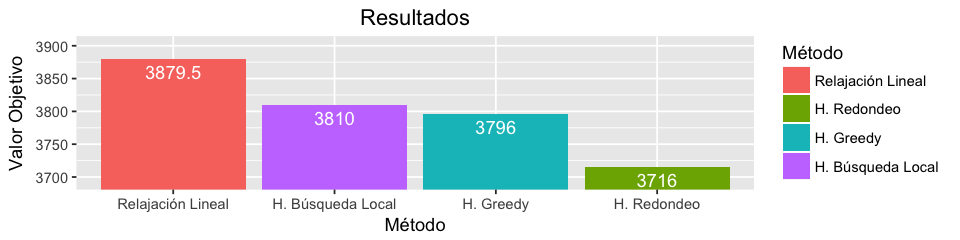

In [43]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen100_4.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen100.5

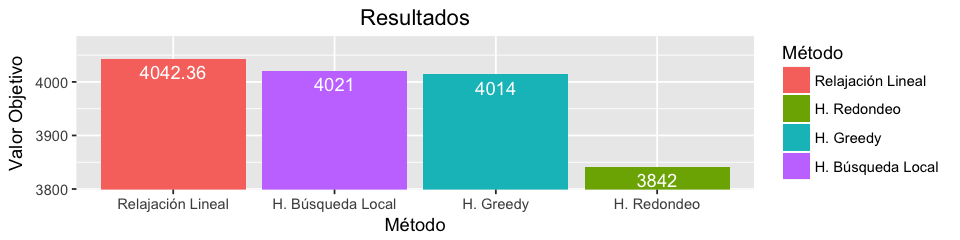

In [44]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen100_5.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen200.1

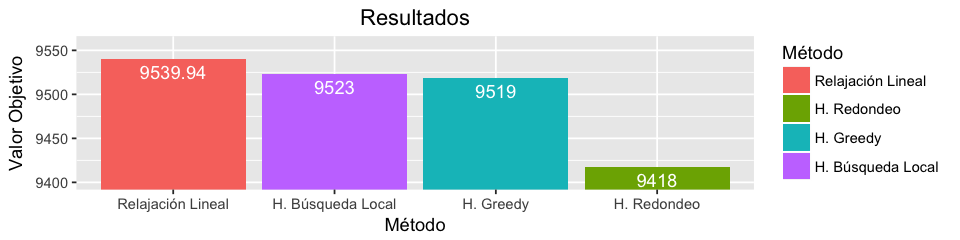

In [45]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen200_1.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

##### gen200.2

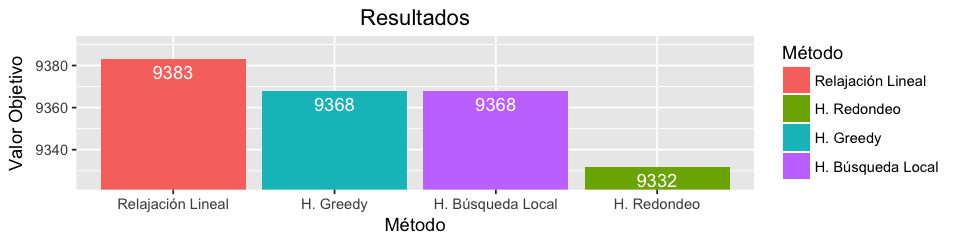

In [46]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen200_2.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen200.3

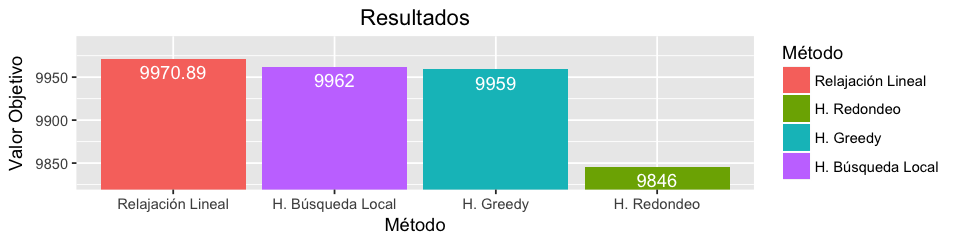

In [47]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen200_3.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen200.4

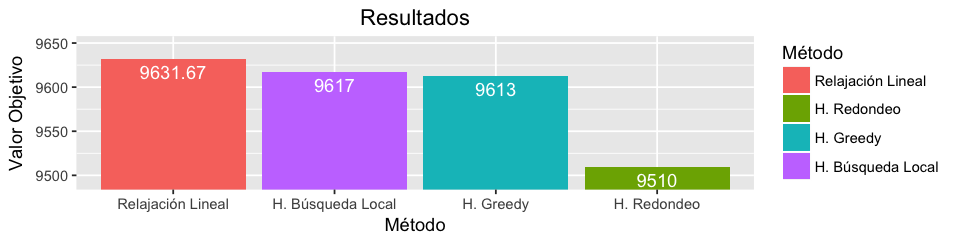

In [48]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen200_4.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen200.5

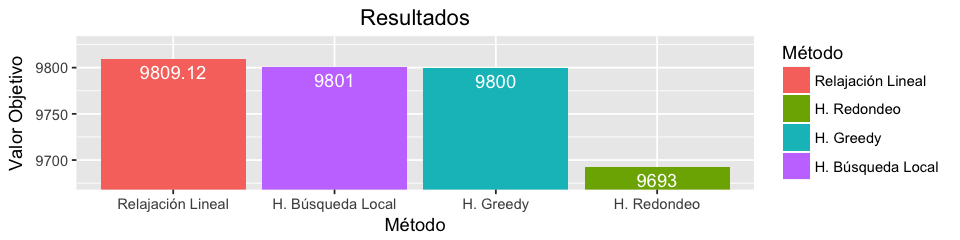

In [49]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen200_5.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen300.1

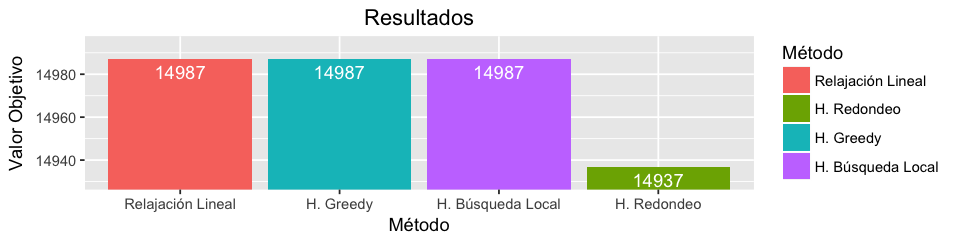

In [50]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen300_1.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen300.2

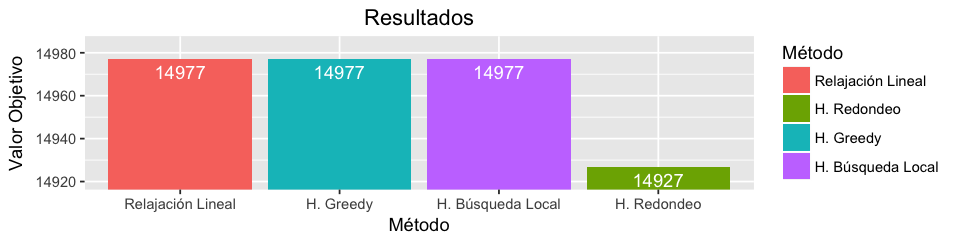

In [51]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen300_2.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen300.3

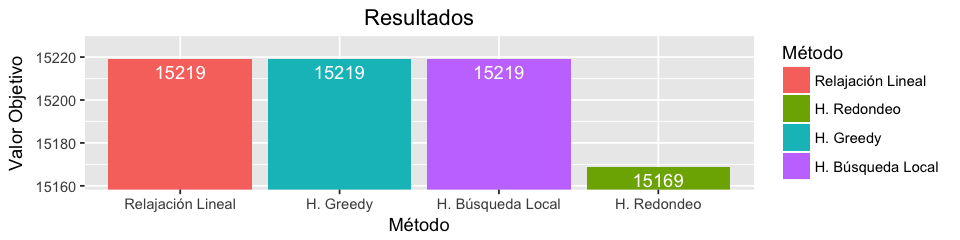

In [52]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen300_3.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen300.4

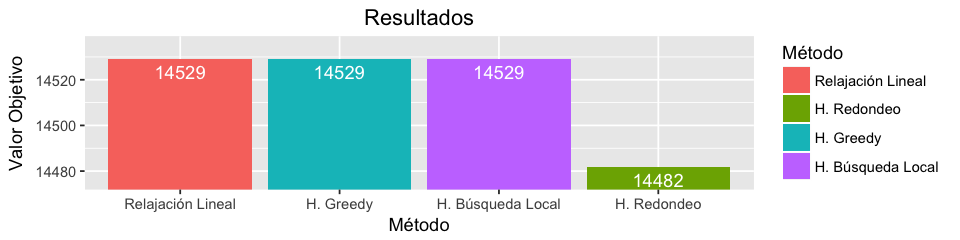

In [53]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen300_4.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

##### gen300.5

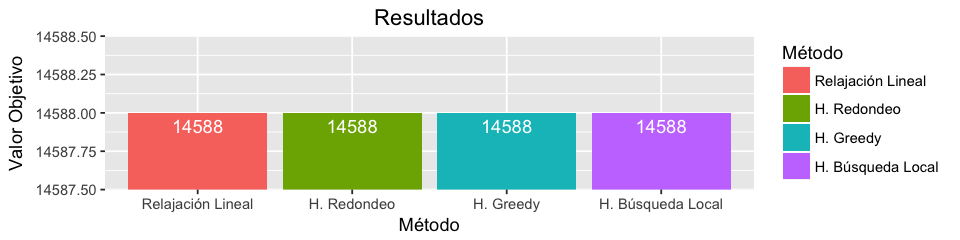

In [54]:
ReadSimpleKnapsack(paste0(dataset.folder.simple, "gen300_5.txt")) %>%
GenerateMultipleKnapsackSolutions(m) %>%
PlotKnapsackSolutions()

TODO(@garciparedes): Analyze results

### Mochila Multidimensional

#### Descripción:
TODO

#### Modelo:
TODO

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Minimizar} & \displaystyle \sum\limits_{j=1}^{n} c_{ij} \cdot x_{ij} \\
      \text{sujeto a}  & \sum\limits_{j=1}^{n} a_{ij} \cdot x_{j} \leq b_{i}, & \forall i \in \{1,...,m\} \\
                       & x_{j} \in \{0, 1\}, & \forall j \in \{1,...,n\}
    \end{array}
\end{equation}

In [55]:
KnapsackMultidimensionalExact <- function(p, types = "B", max = TRUE, ...) {
    Solve(p$value, rbind(p$weight, diag(p$n)), rep("<=", length(p$capacity) + p$n), 
          c(p$capacity, rep(1, p$n)), types = types, max = max, ...)
}

#### Heurísticas:
TODO

In [56]:
KnapsackMultidimensionalRounding <- function(p, m, InitialSolution = KnapsackMultidimensionalExact, 
                                     RoundingFunction = floor, ...) {
    sol.exact <- InitialSolution(p, types = "C", ...)
    
    sol <- list()
    sol$solution = RoundingFunction(sol.exact$solution)
    sol$objval   = sum(sol$solution * p$value)
    sol$slack    = p$capacity - colSums(sol$solution * t(p$weight))
    return(sol)
}

In [57]:
MultidimensionalCriterionRelative <- function(g, p, sol, dim.weight = rep(1, p$m)) {
    if (!is.null(g)) {
        g
    } else {
        p$value / colSums(dim.weight * p$weight)
    }
}

In [58]:
MultidimensionalCriterionShortage <- function(g, p, sol, dim.weight = rep(1, p$m)) {
    MultidimensionalCriterionRelative(g, p, sol, dim.weight = 1  / sol$slack)
}

In [59]:
MultidimensionalCriterionRelaxed <- function(g, p, sol) {
    if (!is.null(g)) {
        g
    } else {
        KnapsackMultidimensionalExact(p, types = "C" )$solution
    }
}

In [60]:
MultidimensionalCriterionSlack <- function(g, p, sol) {
    if (!is.null(g)) {
        g
    } else {
        MultidimensionalCriterionRelative(g, p, sol, 
            dim.weight = KnapsackMultidimensionalExact(p, types = "C" )$auxiliary$primal[1:p$m]
        )
    }
}

In [61]:
KnapsackMultidimensionalGreedy <- function(p, Criterion = MultidimensionalCriterionRelative, ...) {
        sol <- list(solution = rep(0, p$n), 
                objval = 0, slack = p$capacity)
    
    g <- Criterion(NULL, p, sol)
    i <- which(g == max(g[sol$solution == 0]) & sol$solution == 0)[1]
    
    while (!is.na(i) && all(sol$slack - p$weight[,i] > 0)) {
        sol$solution[i] <- 1
        sol$objval <- sol$objval + p$value[i]
        sol$slack <- sol$slack - p$weight[,i]
        g <- Criterion(g, p, sol)
        if (any(sol$solution == 0)) {
            i <- which(g == max(g[sol$solution == 0]) & sol$solution == 0)[1]
        } else {
            i <- NA
        }
    }
    return(sol)
}

In [62]:
KnapsackMultidimensionalLocalSearchBest <- function(p, slack, idx0, idx1) {
    best = list(v = 0, i = 0, j = 0)
    for (i in idx0) {
        for (j in idx1) {
            if (all(slack + p$weight[, j] - p$weight[, i] > 0)) {
                v.temp <- p$value[i] - p$value[j]
                if (best$v < v.temp) {
                    best$v <- v.temp
                    best$i <- i
                    best$j <- j
                }   
            }
        }
    }
    return(best)
}

In [63]:
KnapsackMultidimensionalLocalSearch <- function(p, InitialSolution = KnapsackMultidimensionalGreedy, ...) {
    sol <- InitialSolution(p, ...)
    
    idx0 <- which(sol$solution == 0)
    idx1 <- which(sol$solution == 1)
    
    best <- KnapsackMultidimensionalLocalSearchBest(p, sol$slack, idx0, idx1)
    while (best$v > 0) {
        sol$solution[best$i] <- 1
        sol$solution[best$j] <- 0
        sol$slack <- sol$slack + p$weight[, best$j] - p$weight[, best$i]
        sol$objval <- sol$objval + best$v
        
        idx0 <- c(idx0[idx0 != best$i], best$j)
        idx1 <- c(idx1[idx1 != best$j], best$i)
        
        best <- KnapsackMultidimensionalLocalSearchBest(p, sol$slack, idx0, idx1)
    }
    return(sol)    
}

### Ejemplos

In [64]:
GenerateMultidimensionalKnapsackSolutions <- function(p, ...) {
    sol <- list()
    
    s <- KnapsackMultidimensionalExact(p, ...)
    sol$exact <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                      objval   = s$optimum,
                      slack    = matrix(p$capacity - colSums(s$solution * t(p$weight)), 
                                        ncol = p$m, byrow = TRUE))

    s <- KnapsackMultidimensionalExact(p, types = "C", ...)
    sol$relaxed <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                        objval   = s$optimum,
                        slack    = matrix(p$capacity - colSums(s$solution * t(p$weight)), 
                                          ncol = p$m, byrow = TRUE))

    s <- KnapsackMultidimensionalRounding(p, ...)
    sol$rounded <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                        objval   = s$objval,
                        slack    = matrix(s$slack, ncol = p$m, byrow = TRUE))

    s <- KnapsackMultidimensionalGreedy(p, ...)
    sol$greedy <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                       objval   = s$objval,
                       slack    = matrix(s$slack, ncol = p$m, byrow = TRUE))

    s <- KnapsackMultidimensionalLocalSearch(p, ...)
    sol$local <- list(solution = matrix(s$solution, ncol = p$n, byrow = TRUE),
                      objval   = s$objval, 
                      slack    = matrix(s$slack, ncol = p$m, byrow = TRUE))
    
    return(sol)
}

##### mknap1.2

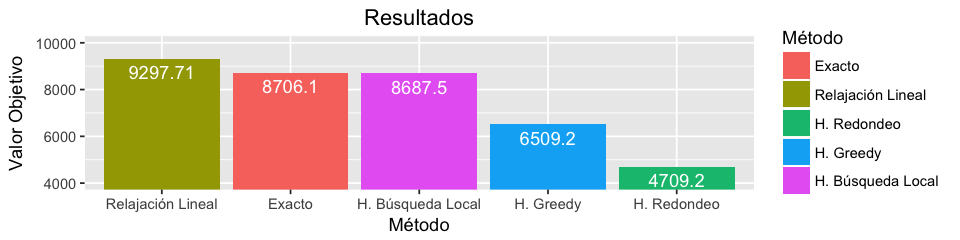

In [65]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknap1_2.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknap1.3

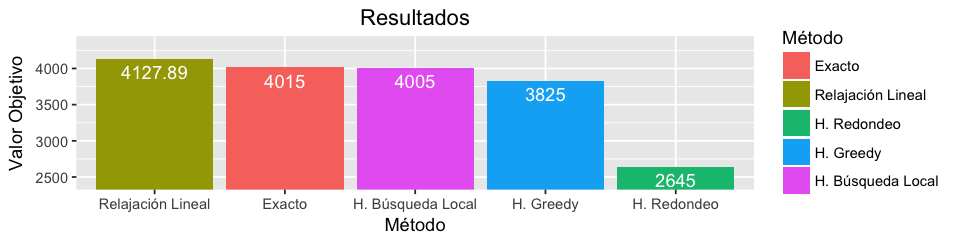

In [66]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknap1_3.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknap1.4

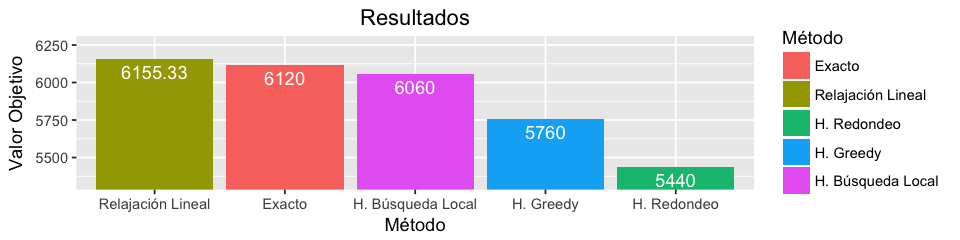

In [67]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknap1_4.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknap1.6

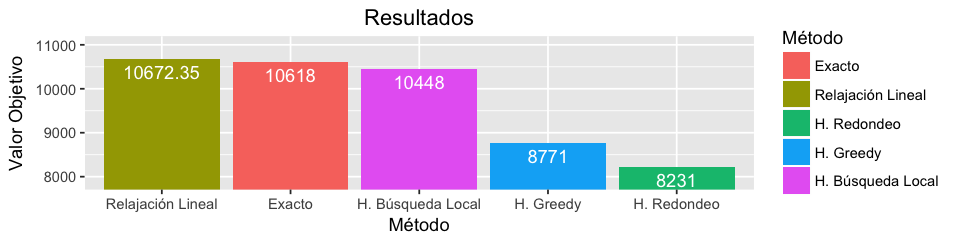

In [68]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknap1_6.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknap1.7

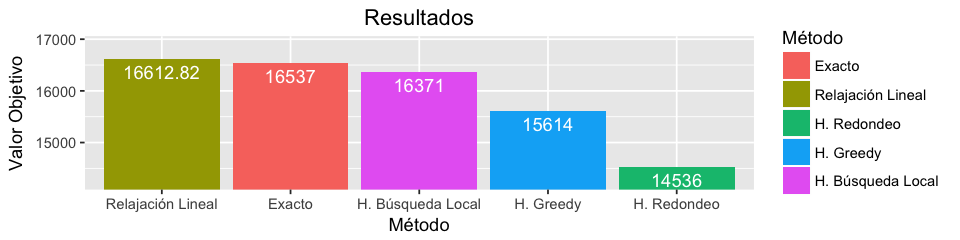

In [69]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknap1_7.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknapcb1.1

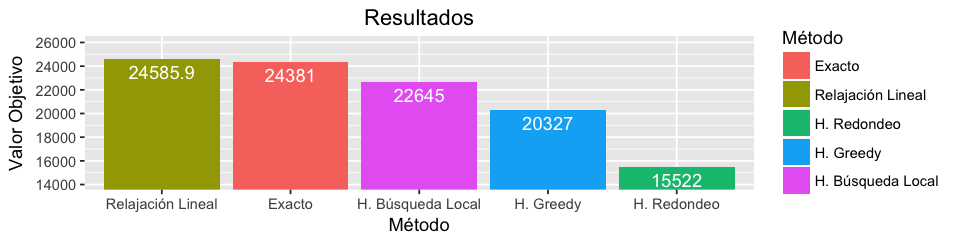

In [70]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknapcb1_1.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknapcb1.2

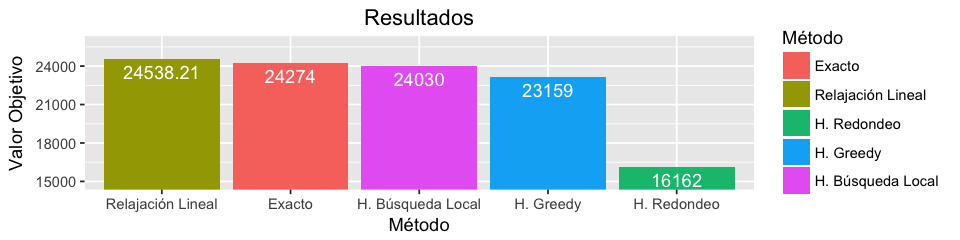

In [71]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknapcb1_2.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknapcb1.3

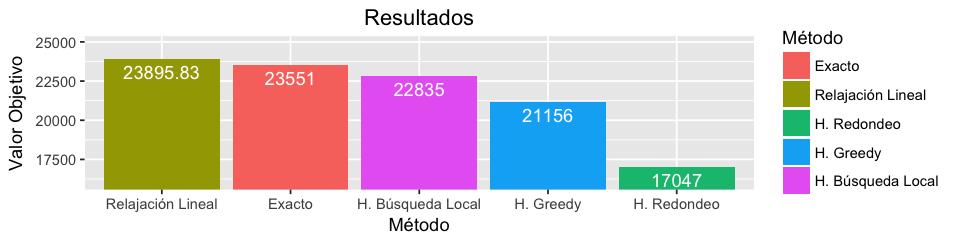

In [72]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknapcb1_3.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknapcb1.4

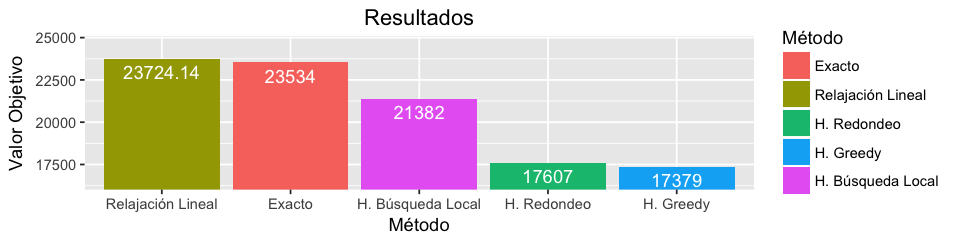

In [73]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknapcb1_4.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

##### mknapcb1.5

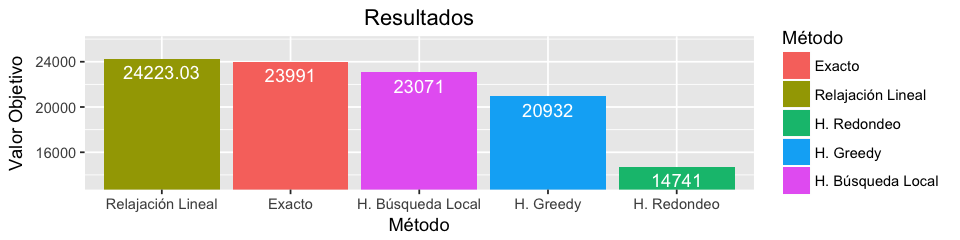

In [74]:
ReadMultidimensionalKnapsack(paste0(dataset.folder.multi, "mknapcb1_5.dat")) %>%
GenerateMultidimensionalKnapsackSolutions() %>%
PlotKnapsackSolutions()

## Problema de Empaquetamiento

#### Descripción:
TODO

### Empaquetamiento Unidimensional

#### Descripción:
TODO

#### Modelo:
TODO

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Minimizar} & \displaystyle \sum\limits_{i=1}^{m} c_{i} \cdot y_{i} \\
      \text{sujeto a}  & \sum\limits_{i=1}^{m} x_{ij} = 1, & \forall j \in \{1,...,n\} \\
                       & \sum\limits_{j=1}^{n} a_{j} \cdot x_{ij} \leq q_{i} \cdot y_{i}, & \forall i \in \{1,...,m\} \\
                       & x_{ij} \in \{0, 1\}, & \forall i \in \{1,...,m\}, \forall j \in \{1,...,n\} \\
                       & y_{i} \in \{0, 1\}, & \forall i \in \{1,...,m\} 
    \end{array}
\end{equation}

#### Heurísticas:
TODO

In [75]:
OneDimBinPackingFFD <- function(p, ...) {
    sol <- list(bins = 1, solution = list(), 
                slack = c(p$capacity))
    idx.sorted <- order( - p$size)
    for(i in idx.sorted) {
        j <- 1
        while(j < sol$bins && sol$slack[j] < p$size[i]) {
            j <- j + 1
        }
        if (sol$bins == j) {
            sol$bins <- sol$bins + 1
            sol$slack <- c(sol$slack, p$capacity)
            sol$solution[[j]] <- c(i)
        } else {
            sol$solution[[j]] <- c(sol$solution[[j]], i)
        }
        sol$slack[j] <- sol$slack[j] - p$size[i]
    }
    if (sol$slack[sol$bins] == p$capacity) {
        sol$slack <- head(sol$slack, -1)
        sol$bins <- sol$bins - 1
    }
    return(sol)
}

### Ejemplos

In [76]:
PlotBinPacking <- function(p, Method = OneDimBinPackingFFD) {
    options(repr.plot.height = 3, repr.plot.width = 9)
    p %>% {
        s <- Method(.)
        lapply(s$solution, function(x) {
        data.frame(id = x, size = .$size[x])
    }) %>% 
    map_df(I, .id = "bin") %>%
    ggplot(aes(x = sprintf("%03d", as.numeric(bin)), 
               y = size, fill = as.character(id))) +
        geom_bar(stat = "sum", show.legend = FALSE)  +
        xlab("Contenedor") +
        ylab("Espacio Ocupado") +
        geom_hline(yintercept  = .$capacity, col = "red") +
        ggtitle(paste0("Problema: ", .$name, "    Contenedores: ", s$bins)) + 
        theme(plot.title       = element_text(hjust = 0.5),
              axis.title.x     = element_blank(),
              axis.text.x      = element_blank(),
              axis.ticks.x     = element_blank(), 
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.background = element_blank())
    }
    
}

##### u120.00

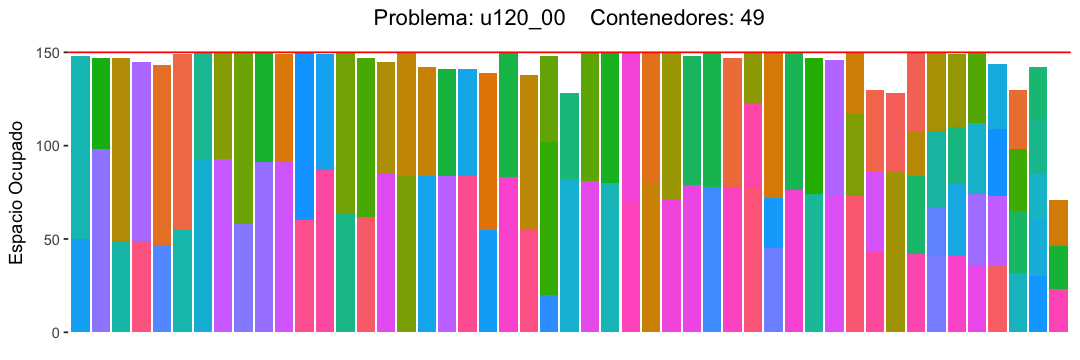

In [77]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u120_00.dat"))  %>%  
PlotBinPacking() 

##### u120.01

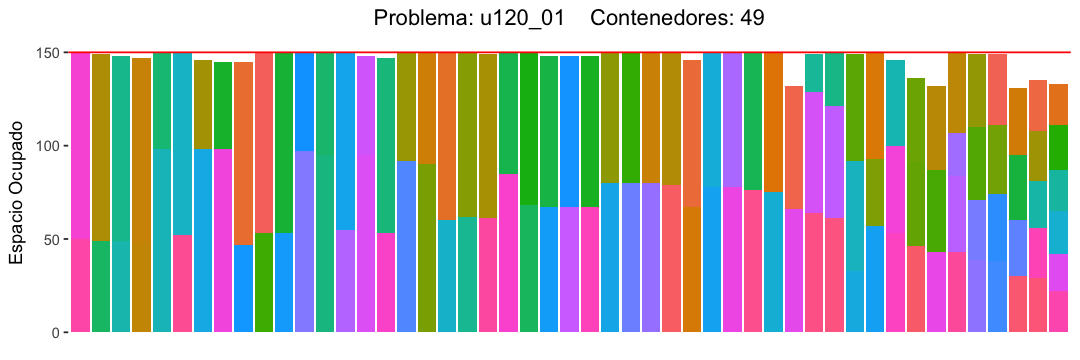

In [78]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u120_01.dat"))  %>%  
PlotBinPacking() 

##### u120.02

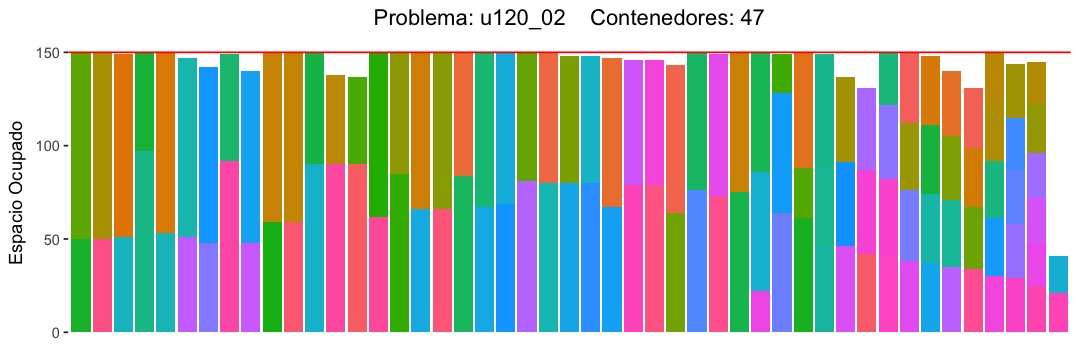

In [79]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u120_02.dat")) %>% 
PlotBinPacking() 

##### u250.00

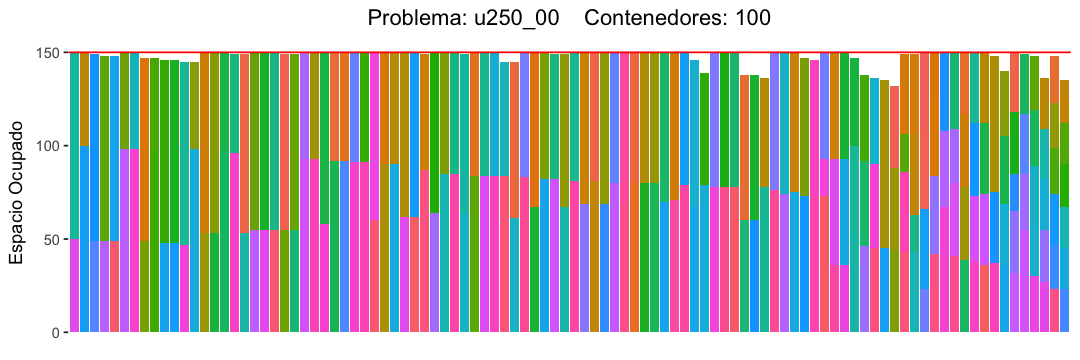

In [80]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u250_00.dat")) %>% 
PlotBinPacking() 

##### u250.01

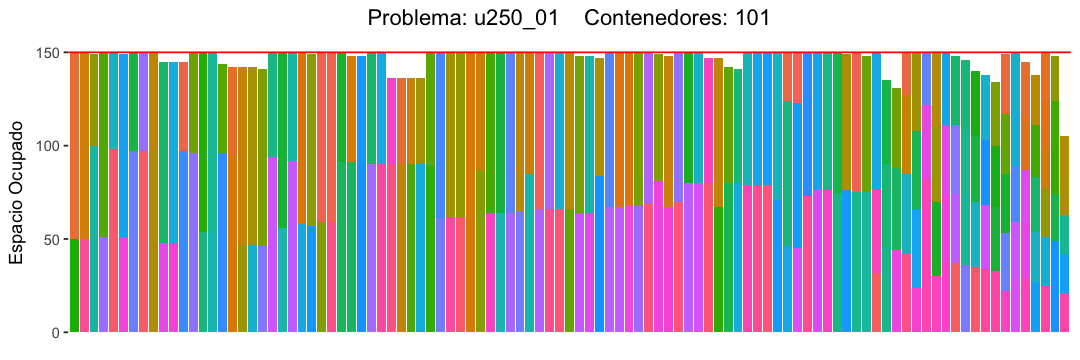

In [81]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u250_01.dat")) %>% 
PlotBinPacking() 

##### u250.02

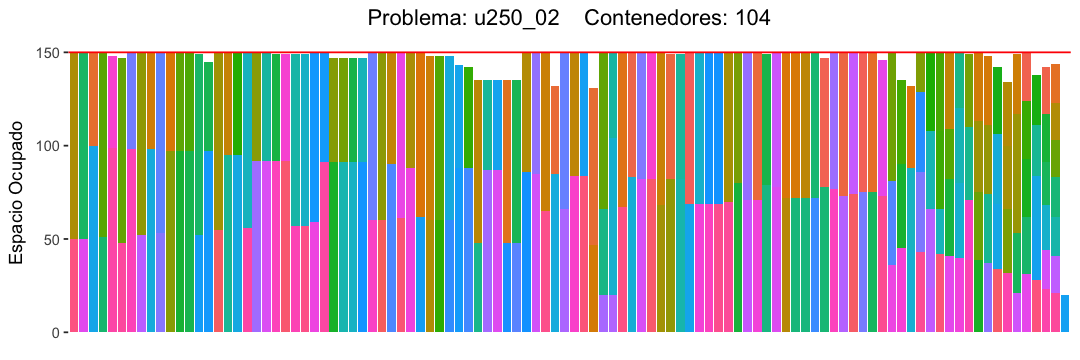

In [82]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u250_02.dat")) %>%
PlotBinPacking() 

##### u500.00

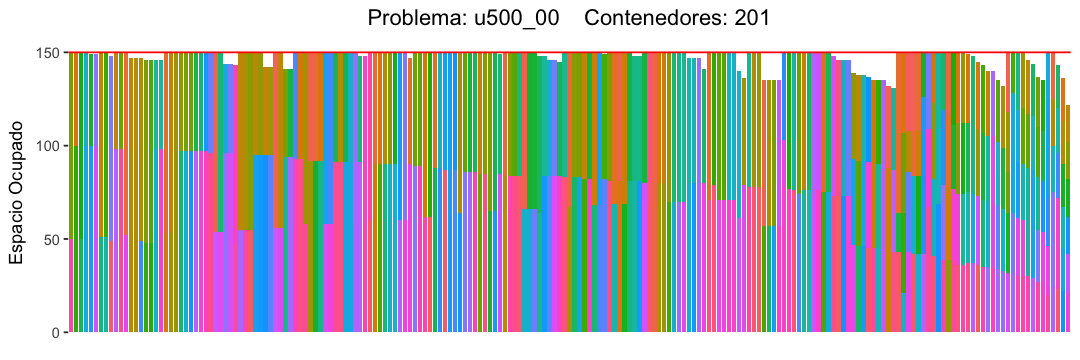

In [83]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u500_00.dat")) %>% 
PlotBinPacking() 

##### u500.01

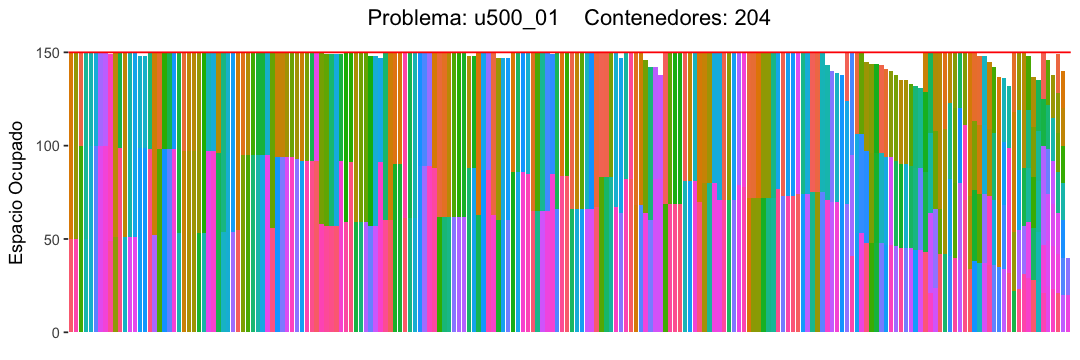

In [84]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u500_01.dat")) %>% 
PlotBinPacking() 

##### u500.02

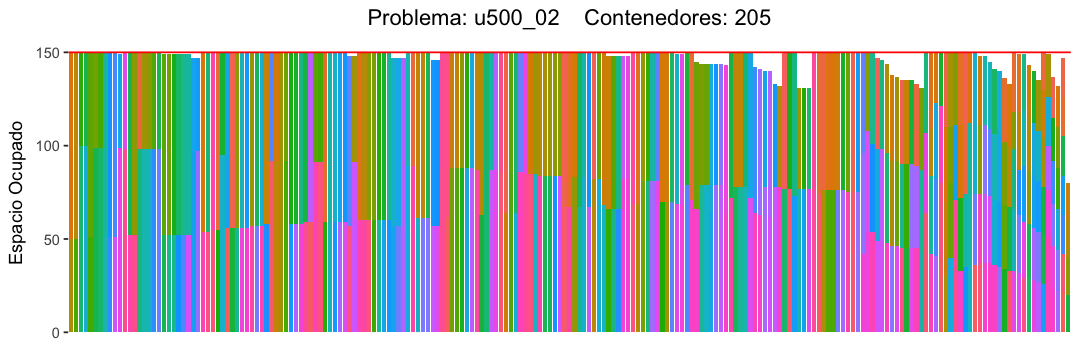

In [85]:
ReadBinPacking(paste0(dataset.folder.binpacking, "u500_02.dat")) %>% 
PlotBinPacking() 

## Conclusiones

TODO

## Referencias

  * [TRC13] Team, R.C., 2013. R: A language and environment for statistical computing.
  * [GP18] Sergio García Prado. Programación Entera: Heurísticas, 2018. [github.com/garciparedes/integer-programming-heuristics](https://github.com/garciparedes/integer-programming-heuristics).
  * [SA18] Jesús Sáez Aguado. Programación Entera, 2017/18. Facultad de Ciencias: Departamento de Estadística e Investigación Operativa.
  * [THBSST17] Theussl, S., Hornik, K., Buchta, C., Schwendinger, F., Schuchardt, H. and Theussl, M.S., 2017. Package ‘Rglpk’.
  